### Install the model:
`! pip install ollama llama-index-llms-ollama`

`! sudo snap install ollama`

`! ollama pull llama3`

### After downloading the base model and creating the modelfile, we create the parametrised model for our task:
`! ollama create [model name] -f [modelfile name]`

In [1]:
from lib.dataset_utils import load_twitter_data_cleaned, load_goemotions_cleaned
from lib.plot_utils import *
from lib.models import Llama3
from lib.dataset_utils import Llama_EmotionsData
from sklearn.metrics import accuracy_score, jaccard_score, f1_score
import json

### Loading Twitter

In [2]:
_, _, twitter_test = load_twitter_data_cleaned() 
twitter_emotions = ('joy', 'sadness','anger', 'fear', 'love', 'surprise')
twitter_test_dataset = Llama_EmotionsData(twitter_test)

### Loading Goemotions

In [3]:
label_mapping_path = "./dataset/GoEmotionsSplit/label_mapping.json"
_, _, goemotions_test = load_goemotions_cleaned()
json1_file = open(label_mapping_path)
json1_str = json1_file.read()
json1_data = json.loads(json1_str)
goemotions_emotions = str(json1_data.values())

In [4]:
def accuracy(targets, predictions):
    return accuracy_score(targets, predictions, zero_division=0)
def jaccard(targets, predictions):
    return jaccard_score(targets, predictions, average='micro', zero_division=0)
def jaccard_samples(targets, predictions):
    return jaccard_score(targets, predictions, average='samples', zero_division=0)
def f1(targets, predictions):
    return f1_score(targets, predictions, average='macro', zero_division=0)
def f1_micro(targets, predictions):
    return f1_score(targets, predictions, average='micro', zero_division=0)

SCORES = {"accuracy": accuracy, "jaccard": jaccard, "jaccard_samples":jaccard_samples, "f1": f1, "f1_micro": f1_micro}

PROMPTS = {"SAMPLES" : """ 
text: 1. i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
2. im updating my blog because i feel shitty

answer:{
    "1": "joy"
    "2": "sadness"
    }
""",
"SINGLE_BASE_PROMPT" : """<|start_header_id|>system<|end_header_id|> Classify the sentences. Choose ONLY ONE EMOTION among the following: """, 

"MULTI_BASE_PROMPT" : """<|start_header_id|>system<|end_header_id|> Classify the sentences. Choose a maximum of three emotions among the following: """, 

"SAMPLES_STRING" : """Here are some samples:""",

"TERMINATOR_STRING" : """<|eot_id|>"""}

# Twitter 2-Shot

100%|██████████| 250/250 [1:54:51<00:00, 27.57s/it]
/home/nsiva/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         joy       0.45      0.45      0.45       275
     sadness       0.31      0.48      0.38       224
       anger       0.74      0.39      0.52       695
        fear       0.22      0.45      0.29       159
        love       0.58      0.38      0.46       581
    surprise       0.12      0.36      0.18        66

   micro avg       0.43      0.41      0.42      2000
   macro avg       0.40      0.42      0.38      2000
weighted avg       0.54      0.41      0.45      2000
 samples avg       0.41      0.41      0.41      2000

{'accuracy': 0.4105, 'jaccard': 0.2667316439246264, 'jaccard_samples': 0.4105, 'f1': 0.3789845035884605, 'f1_micro': 0.4211336240061554}


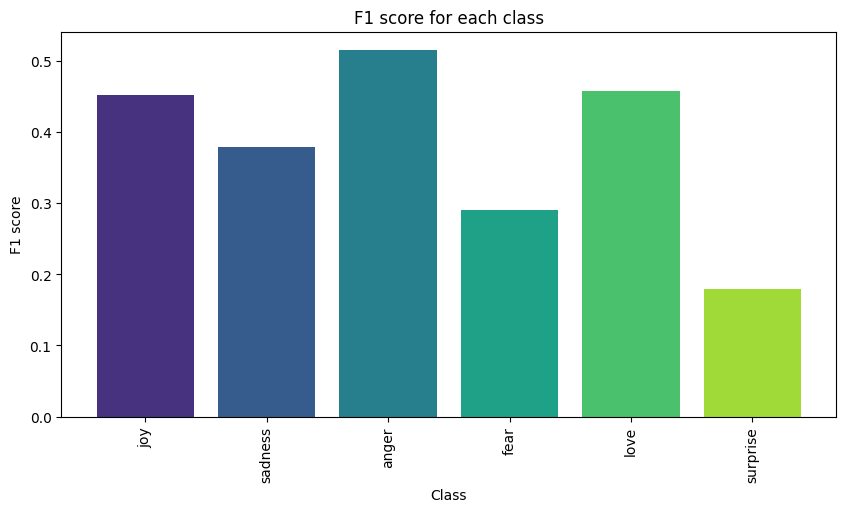

In [6]:
llama3 = Llama3("ParametrisedLlama3", scores = SCORES, json_mode=False, samples=PROMPTS["SAMPLES"])
predictions, results = llama3.predict(twitter_emotions, twitter_test_dataset, single_label = True, progress_bar = True)